<a href="https://colab.research.google.com/github/ngohiep-noob/facial-emotional-classification/blob/main/emotional_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import cv2 as cv
from skimage import feature
from skimage import io
import os
import numpy as np
import random

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
path = 'drive/MyDrive/data'

In [4]:
label_names = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

In [5]:
def read_data(path, percent=1.0):
  labels = []
  images = []
  listDir = os.listdir(path)
  print('Summary ')

  for dir_name in listDir:
    label = label_names[int(dir_name)]
    img_list = os.listdir(os.path.join(path, dir_name))

    num_images = round(len(img_list) * percent)
    selected_images = random.sample(img_list, num_images)

    print(f"\t{label}: {num_images} images")

    for img_name in selected_images:
        labels.append(dir_name)
        img_path = os.path.join(path, dir_name, img_name)
        images.append(io.imread(img_path))

  return labels, images

In [6]:
train_labels, train_images = read_data(path + '/train', 0.5)

Summary 
	sad: 2415 images
	surprise: 1586 images
	neutral: 2482 images
	fear: 2048 images
	disgust: 218 images
	happy: 3622 images
	angry: 1998 images


In [7]:
len(train_labels)

14369

In [8]:
test_labels, test_images = read_data(path + '/test', 0.5)

Summary 
	sad: 297 images
	happy: 440 images
	disgust: 28 images
	neutral: 313 images
	fear: 264 images
	surprise: 208 images
	angry: 246 images


In [9]:
len(test_labels)

1796

# Sobel

In [10]:
def compute_sobel_features(imgs):
  features = []
  for img in imgs:
    gray = img
    scale = 1
    delta = 0
    ddepth = cv.CV_16S

    grad_x = cv.Sobel(gray, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv.BORDER_DEFAULT)
    # Gradient-Y
    #grad_y = cv.Scharr(gray,ddepth,0,1)
    grad_y = cv.Sobel(gray, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv.BORDER_DEFAULT)


    abs_grad_x = cv.convertScaleAbs(grad_x)
    abs_grad_y = cv.convertScaleAbs(grad_y)

    grad = cv.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    features.append(grad.flatten())

  return features;

In [11]:
train_freatures = compute_sobel_features(train_images)
test_freatures = compute_sobel_features(test_images)

# HOG

In [12]:
def compute_hog_feature(imgs):
    features = []
    for img in imgs:
      hog = feature.hog(img,
                        orientations=9,
                        pixels_per_cell=(6, 6),
                        cells_per_block=(3, 3),
                        block_norm='L2')
      #io.imshow(hog_img)
      features.append(hog)
    return np.array(features)

In [13]:
train_freatures = compute_hog_feature(train_images)

In [14]:
test_freatures = compute_hog_feature(test_images)

In [15]:
train_freatures.shape

(14369, 2916)

# PCA

In [16]:
pca = PCA(0.9)
pca.fit(train_freatures)
pca.n_components_

345

In [17]:
pipe = Pipeline([('pca', PCA(0.6)), ('svm', SVC(kernel='rbf', C=10, cache_size=10000))])
pipe.fit(train_freatures, train_labels)

Pipeline(steps=[('pca', PCA(n_components=0.6)),
                ('svm', SVC(C=10, cache_size=10000))])

In [18]:
pipe.score(test_freatures, test_labels)

0.5167037861915368

# SVM

In [19]:
model = SVC(kernel='rbf', C=10, cache_size=10000)
model.fit(X=train_freatures, y=train_labels)

SVC(C=10, cache_size=10000)

In [20]:
predictions = model.predict(test_freatures)

accuracy = accuracy_score(test_labels, predictions)
precision = precision_score(test_labels, predictions, average='weighted')
recall = recall_score(test_labels, predictions, average='weighted')
f1 = f1_score(test_labels, predictions, average='weighted')

# In kết quả đánh giá
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.517260579064588
Precision: 0.5192516171693957
Recall: 0.517260579064588
F1 Score: 0.514814667946935


# LogisticRegression

In [21]:
from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression(max_iter=3000)
logistic_model.fit(X=train_freatures, y=train_labels)

LogisticRegression(max_iter=3000)

In [22]:
logistic_model.score(test_freatures, test_labels)

0.4354120267260579

# KNN

In [23]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=7)
knn_model.fit(train_freatures, train_labels)

KNeighborsClassifier(n_neighbors=7)

In [24]:
knn_model.score(train_freatures, train_labels)

0.577980374417148

In [25]:
knn_model.score(test_freatures, test_labels)

0.4265033407572383

# Neural network

In [26]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

X_train = np.array(train_freatures)
y_train = np.array(label_encoder.fit_transform(train_labels))
X_test = np.array(test_freatures)
y_test = np.array(label_encoder.fit_transform(test_labels))

In [27]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train)
y_train_tensor = torch.from_numpy(y_train)
X_test_tensor = torch.from_numpy(X_test)
y_test_tensor = torch.from_numpy(y_test)

# Create a TensorDataset to combine the input data and labels
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
# Define the batch size for the DataLoader
batch_size = 32

# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [28]:
import torch.nn as nn

class FullyConnectedNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(FullyConnectedNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 32)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(32, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        out = self.softmax(out)
        return out

In [43]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

input_size = 2916
num_classes = 7

fc_model = FullyConnectedNet(input_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(fc_model.parameters(), lr=0.002)

num_epochs = 50

loss_history = []
for epoch in range(num_epochs):
    fc_model.train()
    running_loss = 0.0
    idx = 0
    for inputs, labels in train_loader:  # Assuming train_loader provides mini-batches
        inputs = inputs.to(torch.float32)

        outputs = fc_model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if idx % 50:
          loss_history.append(loss.item())
        idx += 1

    print(
        f"Epoch {epoch+1}/{num_epochs}, Train-Loss: {running_loss:.4f}"
    )

Epoch 1/50, Train-Loss: 813.7064
Epoch 2/50, Train-Loss: 787.1237
Epoch 3/50, Train-Loss: 777.4024
Epoch 4/50, Train-Loss: 770.5728
Epoch 5/50, Train-Loss: 765.1853
Epoch 6/50, Train-Loss: 757.4206
Epoch 7/50, Train-Loss: 750.2513
Epoch 8/50, Train-Loss: 744.6819
Epoch 9/50, Train-Loss: 739.9763
Epoch 10/50, Train-Loss: 734.2017
Epoch 11/50, Train-Loss: 728.0354
Epoch 12/50, Train-Loss: 724.7687
Epoch 13/50, Train-Loss: 720.1872
Epoch 14/50, Train-Loss: 717.2461
Epoch 15/50, Train-Loss: 716.1185
Epoch 16/50, Train-Loss: 713.7106
Epoch 17/50, Train-Loss: 712.7679
Epoch 18/50, Train-Loss: 708.3641
Epoch 19/50, Train-Loss: 703.9253
Epoch 20/50, Train-Loss: 705.3621
Epoch 21/50, Train-Loss: 699.2350
Epoch 22/50, Train-Loss: 699.8494
Epoch 23/50, Train-Loss: 698.2995
Epoch 24/50, Train-Loss: 694.4146
Epoch 25/50, Train-Loss: 694.6731
Epoch 26/50, Train-Loss: 694.3689
Epoch 27/50, Train-Loss: 736.7678
Epoch 28/50, Train-Loss: 708.7110
Epoch 29/50, Train-Loss: 699.2792
Epoch 30/50, Train-Loss

In [44]:
def plot_loss_history(loss_cache):
  plt.grid()
  plt.plot(loss_cache)

  plt.ylabel('Loss', fontsize=20)
  plt.xlabel('Batch', fontsize=20)

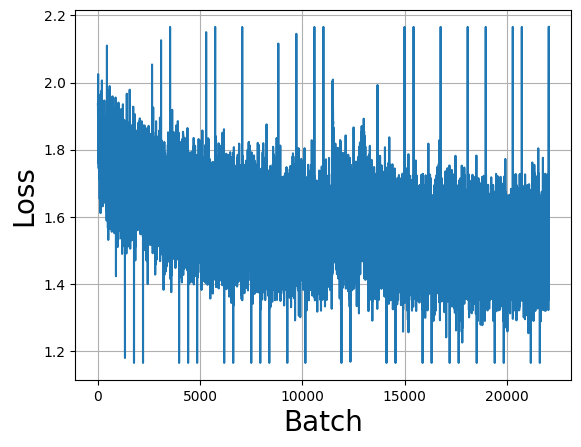

In [45]:
plot_loss_history(loss_history)

In [47]:
num_correct = 0
num_samples = 0
fc_model.eval()

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(torch.float32)

        scores = fc_model(x)
        _, predictions = scores.max(1)
        num_correct += (predictions == y).sum()
        num_samples += predictions.size(0)

    print(f"{num_correct}/{num_samples} -> {float(num_correct)/float(num_samples)*100:.2f}%")

820/1796 -> 45.66%
